In [1]:
# Imports
import random
import string
import tempfile
import shutil
import subprocess as sp
import os

from PIL import Image
from torch import nn as nn
from torch import Generator
from torch.utils.data import random_split,DataLoader
# TODO: Currently assumes that pytest runs from project root
from util.car_dataset import check_dir, check_file, CarDataset, DatasetError
from networks.common import *
from networks.CNNbase import CNNBasic

In [2]:
# Helper Functions
def rand_string(length=5):
    return ''.join(random.choices(string.ascii_letters +
        string.digits, k=length))

def loaded_dataset(temp_dir,transform=None,augment=None):
    '''
    Loads the car_dataset and returns the CarDataset object.
    '''
    #image_folder_list = ['0_Frames','1_Frames','2_Frames','3_Frames']
    #label_file_list = ['0.txt','1.txt','2.txt','3.txt']
    image_folder_list = ['0_Frames']
    label_file_list = ['0.txt']
    car_data = CarDataset(temp_dir,image_folder_list,label_file_list,transform=transform,augment=augment)
    car_data.drop_nan()

    return car_data

def dataset_loader(loaded_dataset):
    length = len(loaded_dataset)
    split_set = random_split(loaded_dataset,[round(0.80*length)
                ,round(0.20*length)],generator=Generator().manual_seed(42))
    train_loader = DataLoader(split_set[0],batch_size=20)
    test_loader = DataLoader(split_set[1],batch_size=20)
    '''
    Lowering values to sane levels to help run tests on github
    runners. Ideally on local GPU (4GB) 80/20 split with batch size of
    30 works well.
    '''
    return (train_loader,test_loader)

def network(alpha=0,ip_dim=torch.Size([3,874,1164])):
    network = CNNBasic(alpha,ip_dim)
    network = network.to(get_device())
    network.double()
    return network

In [3]:
root = os.getcwd()
print(os.getcwd())

/home/akshay.viswakumar/dl-based-sensor-calib


In [4]:
# Load Data
data = loaded_dataset(os.path.join(root,"dummy"),transform=['gs','norm','ccrop'],augment=['raff','rer'])

In [5]:
# Split Dataset
datasets = dataset_loader(data)

In [6]:
# Initialize Network
net = network(alpha=0,ip_dim=data[0]['image'].size())

In [7]:
# Set Up Paths and Metadata for Storing Values
test_name = "Baseline"
checkpoint_path = os.path.join(root,"Test-Results",test_name)

In [8]:
import matplotlib.pyplot as plt

In [9]:
def tf_plot(image,cmap=None):
    plt.figure()
    plt.imshow(image.permute(1, 2, 0),cmap=cmap)

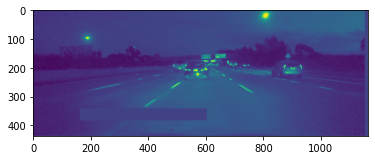

In [10]:
a = data[-1]['image']
tf_plot(a)

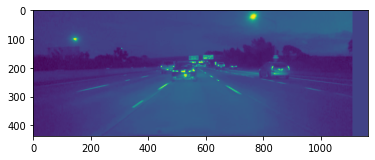

In [11]:
b = data[-1]['image']
tf_plot(b)

In [12]:
(a - b).sum()

tensor(-27711.4844)

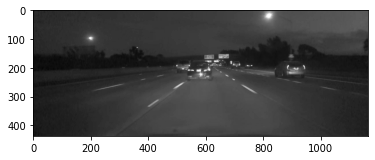

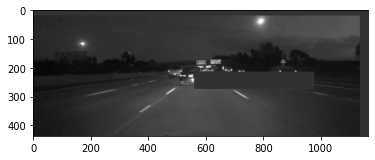

In [13]:
data.mode = 'eval'
c = data[-1]['image']
tf_plot(c,cmap='gray')
data.mode = 'train'
d = data[-1]['image']
tf_plot(d,cmap='gray')

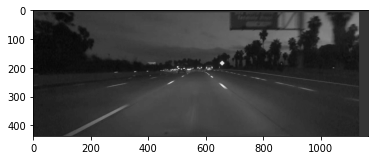

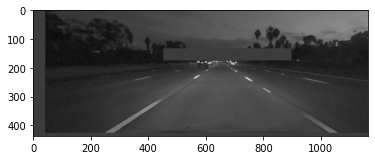

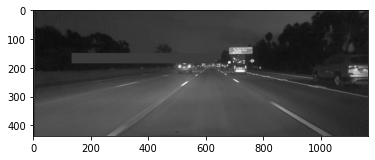

In [14]:
i = 1
for batch_idx,sample in enumerate(datasets[0]):
    d = sample['image']
    i-=1
    if i==0:
        break

tf_plot(d[0,:,:,:],cmap='gray')
tf_plot(d[1,:,:,:],cmap='gray')
tf_plot(d[-1,:,:,:],cmap='gray')

In [15]:
data.mode

'train'

In [16]:
run_training(net,datasets[0],datasets[1],1,get_device(),dataset=data)

48it [00:32,  1.50it/s]


Setting Dataset Mode to eval
Num = 12
Len = 240
Test Set Average Loss 0.000707
Setting Dataset Mode to train
Train Epoch: 0	Train Loss: 0.004712 Test Loss:0.000707


([0.004712236710085107], [0.0007071002972699966])

In [17]:
run_inference(net,datasets[1],get_device(),dataset=data)

Setting Dataset Mode to eval
Num = 12
Len = 240
Test Set Average Loss 0.000707
Setting Dataset Mode to train


0.0007071002972699966

In [18]:
run_inference(net,datasets[1],get_device())

Num = 12
Len = 240
Test Set Average Loss 0.000684


0.0006836831921059565

In [19]:
data.mode

'train'

In [20]:
run_inference(net,datasets[1],get_device(),dataset=data)

Setting Dataset Mode to eval
Num = 12
Len = 240
Test Set Average Loss 0.000707
Setting Dataset Mode to train


0.0007071002972699966